# Comprehensive review of stop segments from March - July 2023

* Use heuristics to narrow down which shapes may be problematic still
* The sum of the segment lengths may be close to the shape length, but may not be exactly. What threshold should we use to figure out how to plug in the large gaps?
   * Large gaps....if we plugged it in as one piece, we could use the difference of the entire shape against the sum of the segments, but if they're disjointed, we'd get segments that don't have attributes associated with `shape_array_key-stop_sequence`
   * Are there other ways to narrow down the `shape_array_key-stop_sequence` so that the same `stop_id`, but different `stop_sequences` somehow get consolidated as 1 entry instead of multiple?
   * Perhaps distance from the prior? If it's zero, we throw that row away, so we can minimize the number of short segments
   * We already expect zero to be the length of the first segment (which is origin of shape to first stop. where origin of shape is not present, it's just first stop to first stop)
* Are there shapes that are cut correctly one month but not in a different month?
* Are the segments with gaps on shapes that are `loop_or_inlining==1` or also `loop_or_inlining==0`? 

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd

from dask import delayed, compute

from shared_utils import rt_dates
from segment_speed_utils import helpers
from segment_speed_utils.project_vars import SEGMENT_GCS

In [2]:
months = [#"mar", "apr", "may", 
          "jun", "jul"]

dates = [
    rt_dates.DATES[f"{m}2023"] for m in months
]
dates

['2023-06-14', '2023-07-12']

In [3]:
def import_segments(date: str) -> gpd.GeoDataFrame:
    
    gdf = gpd.read_parquet(
        f"{SEGMENT_GCS}stop_segments_{date}.parquet",
        columns = ["gtfs_dataset_key", "feed_key", 
                   "shape_array_key", "stop_id", "stop_sequence",
                   "loop_or_inlining", "geometry"
                  ]
    )
    gdf = gdf.assign(
        segment_length = gdf.geometry.length,
        service_date = date
    )
    
    return gdf

segment_dfs = [
    delayed(import_segments)(d) for d in dates
]

In [4]:
for df in segment_dfs:
    by_shape = df.drop_duplicates(subset="shape_array_key")
    
    loop_proportion = compute(
        by_shape.loop_or_inlining.value_counts(
        normalize=True)
    )[0]
    
    print(loop_proportion)
    
    print(
        compute(by_shape.crs.to_epsg())[0]
    )

0    0.832315
1    0.167685
Name: loop_or_inlining, dtype: float64
3310
0    0.828773
1    0.171227
Name: loop_or_inlining, dtype: float64
3310


In [5]:
gdf = import_segments(dates[-1])

gdf = gdf.assign(
    sum_segment_length = (gdf.groupby(["shape_array_key", "service_date"])
                          .segment_length
                          .transform("sum")
                         )
)

In [6]:
# Is Metrolink or Amtrak still present in scheduled shapes?
# the to_crs is taking so long
shape_keys_present = gdf.shape_array_key.unique().tolist()

In [7]:
gdf2 = gdf[["shape_array_key", "loop_or_inlining", 
            "service_date", "sum_segment_length"]
          ].drop_duplicates().reset_index(drop=True)

In [8]:
shapes = helpers.import_scheduled_shapes(
    dates[-1],
    filters = [[("shape_array_key", "in", shape_keys_present)]],
    get_pandas = True, 
)

In [9]:
shapes = shapes.assign(
    shape_length = shapes.geometry.length
)

shapes2 = pd.merge(
    shapes,
    gdf2,
    on = "shape_array_key",
    how = "inner",
)

In [10]:
shapes2 = shapes2.assign(
    difference_meters = (shapes2.sum_segment_length - 
                         shapes2.shape_length).round(3)
)

In [11]:
wrong_shape = "e83d24289ce7c96e4b66a85e159c1ebb"
shapes2[shapes2.shape_array_key == wrong_shape]

shape_array_key  \
2359  e83d24289ce7c96e4b66a85e159c1ebb   

                                               geometry  shape_length  \
2359  LINESTRING (149530.186 -465242.734, 149478.821...  47363.709364   

      loop_or_inlining service_date  sum_segment_length  difference_meters  
2359                 0   2023-07-12        47363.709364                0.0

In [12]:
gdf[gdf.shape_array_key == wrong_shape].drop(
    columns = "service_date"
).explore("stop_sequence", 
          categorical=True, tiles="CartoDB Positron")

In [16]:
gdf[gdf.shape_array_key == wrong_shape].head()

gtfs_dataset_key                          feed_key  \
144729  5222fe2cf728fd3f16b2ff51e133fe8c  51636bfd23120ffa6cf553cdd635a71d   
144730  5222fe2cf728fd3f16b2ff51e133fe8c  51636bfd23120ffa6cf553cdd635a71d   
144731  5222fe2cf728fd3f16b2ff51e133fe8c  51636bfd23120ffa6cf553cdd635a71d   
144732  5222fe2cf728fd3f16b2ff51e133fe8c  51636bfd23120ffa6cf553cdd635a71d   
144733  5222fe2cf728fd3f16b2ff51e133fe8c  51636bfd23120ffa6cf553cdd635a71d   

                         shape_array_key stop_id  stop_sequence  \
144729  e83d24289ce7c96e4b66a85e159c1ebb  425382              0   
144730  e83d24289ce7c96e4b66a85e159c1ebb  469206              1   
144731  e83d24289ce7c96e4b66a85e159c1ebb  469207              2   
144732  e83d24289ce7c96e4b66a85e159c1ebb  469208              3   
144733  e83d24289ce7c96e4b66a85e159c1ebb  486118              4   

        loop_or_inlining                                           geometry  \
144729                 0  LINESTRING (149530.186 -465242.734, 149530.186...   
144730                 0  LINESTRING (149530.186 -465242.734, 149530.186...   
144731                 0  LINESTRING (149359.173 -465283.357, 149359.173...   
144732                 0  LINESTRING (149231.621 -464955.109, 149231.621...   
144733                 0  LINESTRING (149213.196 -464601.268, 149213.196...   

        segment_length service_date  sum_segment_length  
144729        0.000000   2023-07-12        47363.709364  
144730      283.723018   2023-07-12        47363.709364  
144731      356.104346   2023-07-12        47363.709364  
144732      355.496918   2023-07-12        47363.709364  
144733      343.125366   2023-07-12        47363.709364

<AxesSubplot:>

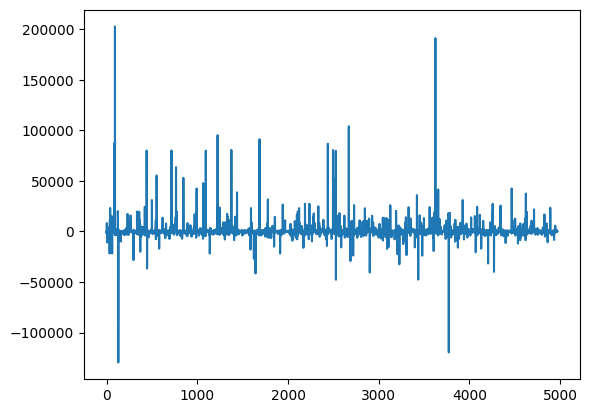

In [14]:
shapes2.difference_meters.plot()

In [19]:
shapes2.difference_meters.describe()

count      4970.000000
mean        468.731694
std        7567.950535
min     -129583.649000
25%         -26.127500
50%          -0.027000
75%          83.581500
max      202835.603000
Name: difference_meters, dtype: float64

<AxesSubplot:>

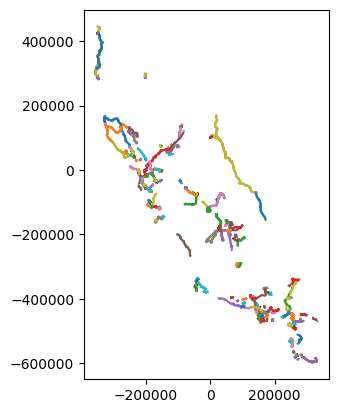

In [31]:
shapes2[(shapes2.difference_meters <= -2_000) | 
        (shapes2.difference_meters >= 2_000)
       ].plot("shape_array_key")

In [32]:
shapes2[(shapes2.difference_meters > 4_000)
       ].drop(columns = "service_date").explore()

In [36]:
debug_shape1 = "e5bfc216bbbf038e7ef4c465ff22baa2"
shapes2[shapes2.shape_array_key == debug_shape1]

shape_array_key  \
2513  e5bfc216bbbf038e7ef4c465ff22baa2   

                                               geometry  shape_length  \
2513  LINESTRING (152410.831 -463530.766, 152409.103...  24702.833193   

      loop_or_inlining service_date  sum_segment_length  difference_meters  
2513                 0   2023-07-12        50381.364896          25678.532

In [45]:
gdf[gdf.shape_array_key==debug_shape1]

gtfs_dataset_key                          feed_key  \
142919  5a3ed004c18b1388ecf8f219f5483043  f0dd23b9fd7039d7f162c8fb9cb2f2b2   
142920  dac1d3922d8cb62f5feba57d5fdfb012  f0dd23b9fd7039d7f162c8fb9cb2f2b2   
142921  5a3ed004c18b1388ecf8f219f5483043  f0dd23b9fd7039d7f162c8fb9cb2f2b2   
142922  dac1d3922d8cb62f5feba57d5fdfb012  f0dd23b9fd7039d7f162c8fb9cb2f2b2   
142923  5a3ed004c18b1388ecf8f219f5483043  f0dd23b9fd7039d7f162c8fb9cb2f2b2   
...                                  ...                               ...   
142998  dac1d3922d8cb62f5feba57d5fdfb012  f0dd23b9fd7039d7f162c8fb9cb2f2b2   
142999  5a3ed004c18b1388ecf8f219f5483043  f0dd23b9fd7039d7f162c8fb9cb2f2b2   
143000  dac1d3922d8cb62f5feba57d5fdfb012  f0dd23b9fd7039d7f162c8fb9cb2f2b2   
143001  5a3ed004c18b1388ecf8f219f5483043  f0dd23b9fd7039d7f162c8fb9cb2f2b2   
143002  dac1d3922d8cb62f5feba57d5fdfb012  f0dd23b9fd7039d7f162c8fb9cb2f2b2   

                         shape_array_key stop_id  stop_sequence  \
142919  e5bfc216bbbf038e7ef4c465ff22baa2       2              1   
142920  e5bfc216bbbf038e7ef4c465ff22baa2       2              1   
142921  e5bfc216bbbf038e7ef4c465ff22baa2     249              2   
142922  e5bfc216bbbf038e7ef4c465ff22baa2     249              2   
142923  e5bfc216bbbf038e7ef4c465ff22baa2     179              3   
...                                  ...     ...            ...   
142998  e5bfc216bbbf038e7ef4c465ff22baa2     543             40   
142999  e5bfc216bbbf038e7ef4c465ff22baa2     544             41   
143000  e5bfc216bbbf038e7ef4c465ff22baa2     544             41   
143001  e5bfc216bbbf038e7ef4c465ff22baa2     547             42   
143002  e5bfc216bbbf038e7ef4c465ff22baa2     547             42   

        loop_or_inlining                                           geometry  \
142919                 0  LINESTRING (152410.831 -463530.766, 152410.831...   
142920                 0  LINESTRING (152410.831 -463530.766, 152410.831...   
142921                 0  LINESTRING (152410.831 -463530.766, 152410.831...   
142922                 0  LINESTRING (152410.831 -463530.766, 152410.831...   
142923                 0  LINESTRING (152919.494 -463580.483, 152919.494...   
...                  ...                                                ...   
142998                 0  LINESTRING (162599.361 -458430.691, 162599.361...   
142999                 0  LINESTRING (163240.139 -458395.273, 163240.139...   
143000                 0  LINESTRING (163240.139 -458395.273, 163240.139...   
143001                 0  LINESTRING (163708.040 -458369.913, 163708.040...   
143002                 0  LINESTRING (163708.040 -458369.913, 163708.040...   

        segment_length service_date  sum_segment_length  
142919        0.000000   2023-07-12        50381.364896  
142920        0.000000   2023-07-12        50381.364896  
142921     1348.468913   2023-07-12        50381.364896  
142922     1348.468913   2023-07-12        50381.364896  
142923      397.145744   2023-07-12        50381.364896  
...                ...          ...                 ...  
142998      656.139905   2023-07-12        50381.364896  
142999      483.784437   2023-07-12        50381.364896  
143000      483.784437   2023-07-12        50381.364896  
143001     1258.379194   2023-07-12        50381.364896  
143002     1258.379194   2023-07-12        50381.364896  

[84 rows x 10 columns]

In [38]:
stops_projected = gpd.read_parquet(
    f"{SEGMENT_GCS}stops_projected_{dates[-1]}/",
    filters = [[("shape_array_key", "==", debug_shape1)]],
    columns = [
        "feed_key",
        "shape_array_key", 
        "stop_id", "stop_sequence", 
        "shape_meters", "loop_or_inlining", 
        "stop_geometry", "geometry"
    ]
)

In [42]:
stops_projected.sort_values("stop_sequence")

1     1
32    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
33    1
2     1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
23    1
22    1
21    1
20    1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
42    1
Name: stop_sequence, dtype: int64

In [ ]:
stops_projected = stops_projected.assign(
    prior_shape_meters = (stops_projected.sort_values(
                            ["shape_array_key", "stop_sequence"])
                          .groupby("shape_array_key", 
                                   observed=True, group_keys=False)
                          .shape_meters
                          .apply(lambda x: x.shift(1), 
                                )
                         )
)

stops_projected = stops_projected.assign(
    change_meters = stops_projected.shape_meters - stops_projected.prior_shape_meters
)

In [ ]:
stops_projected[stops_projected.stop_sequence >= 38][
    ["feed_key", "stop_id", "stop_sequence", 
     "shape_meters", "change_meters"]]

In [ ]:
trips = helpers.import_scheduled_trips(
    dates[-1],
    filters = [[("shape_array_key", "==", wrong_shape)]],
    columns = ["feed_key", "trip_id", "shape_array_key"],
    get_pandas = True
)

wrong_trips = trips.trip_id.unique().tolist()

In [ ]:
test_feed = "51636bfd23120ffa6cf553cdd635a71d"

st = helpers.import_scheduled_stop_times(
    dates[-1],
    filters = [[("feed_key", "==", test_feed), 
                ("trip_id", "in", wrong_trips)
               ]],
    columns = ["feed_key", "trip_id", "stop_sequence", "stop_id"]
).compute()

In [ ]:
num_stops = (st.groupby(["feed_key", "trip_id"], 
                        observed=True, group_keys=False)
             .agg({"stop_sequence": "count"})
             .reset_index()
            )

In [ ]:
test_trips = num_stops.tail(2).trip_id.unique().tolist()

In [ ]:
st2 = (st.groupby(["feed_key", "trip_id"], 
                  observed=True, group_keys=False)
       .agg({"stop_id": lambda x: list(x),
           "stop_sequence": lambda x: list(x)})
       .reset_index()
      )

In [ ]:
st[st.stop_id=="426249"]

In [ ]:
st[st.stop_sequence==38]

In [ ]:
# Depending on the shift, it's not clear whether we can use min/max
# Need a solution that keeps the sequence within trip and
# move away from between trip
st[(st.trip_id.isin(test_trips)) & 
   (st.stop_sequence >= 38) & (st.stop_sequence <= 40)
  ].sort_values(["stop_sequence", "stop_id"])